## This notebook will construct the nodes and edges that we will build our graph with

Import relevant libraries and import raw data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

Here we use scipy's function "find_peaks" to find all peaks in each individual spectra sample as well as pulling featurse such as prominence and width of peaks

In [3]:
peaks = []
widths = []
prom = []

for _, group in df.groupby('SpecID'):
    peak_index, weights = find_peaks(x=group['Absorbance'], prominence=75, width=6)
    peaks += list(group.iloc[peak_index].index.values)
    widths += list(weights['widths'])
    prom += list(weights['prominences'])

In [4]:
weights['widths']

array([11.95414873, 13.87562091, 54.71850246, 18.24182504,  6.88883246])

In [5]:
print(len(peaks))

51927


Below shows a scatterplot of the coordinates of all the peaks we have found

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

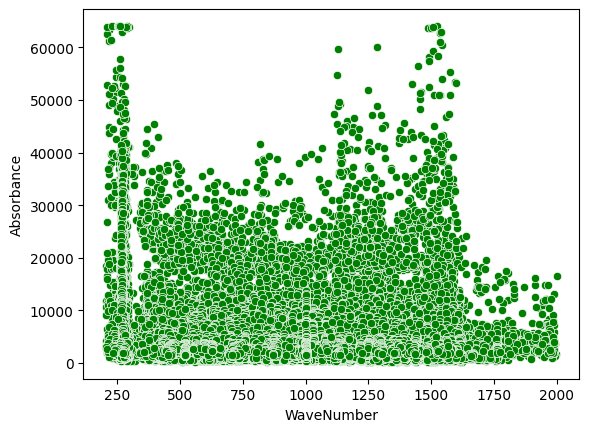

In [6]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", color="green")

We then add the peak information to our main dataframe

In [7]:
peak_df = df.iloc[peaks]
peak_df['Widths'] = widths
peak_df['Prominences'] = prom

/tmp/ipykernel_5766/2901317241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Widths'] = widths
/tmp/ipykernel_5766/2901317241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Prominences'] = prom


In [8]:
peak_df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Widths,Prominences
613,201210-1-00,613,618.90662,1842.5710,201210-1,Normal,57.732793,181.9741
727,201210-1-00,727,696.81091,1851.9185,201210-1,Normal,33.525178,193.5749
1026,201210-1-00,1026,901.13898,1746.4041,201210-1,Normal,107.305604,157.9830
1165,201210-1-00,1165,996.12756,1702.7238,201210-1,Normal,26.861586,115.9938
1964,201210-1-00,1964,1542.14120,1475.0056,201210-1,Normal,15.749470,87.6968
...,...,...,...,...,...,...,...,...
8008132,210526-3-49,367,450.79727,1482.5781,210526-3,Hyperglycemia,11.954149,98.2019
8008234,210526-3-49,469,520.50116,1482.3167,210526-3,Hyperglycemia,13.875621,86.4581
8008504,210526-3-49,739,705.01141,1507.8912,210526-3,Hyperglycemia,54.718502,125.7380
8008936,210526-3-49,1171,1000.22780,1505.2144,210526-3,Hyperglycemia,18.241825,110.7786


We then use the function to assign each peak we have found to a grid slot. We have speicified the slot sizes as they give a meaningful overlap to build our graph

In [9]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [10]:
# Set the size of the grid slots
WaveNumber_slot_size = 50
Absorbance_slot_size = 1000

peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)

/tmp/ipykernel_5766/3240670544.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)


In [11]:
peak_df['GridSlot'].nunique()

1173

In [12]:
peak_df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Widths,Prominences,GridSlot
613,201210-1-00,613,618.90662,1842.5710,201210-1,Normal,57.732793,181.9741,"(12, 1)"
727,201210-1-00,727,696.81091,1851.9185,201210-1,Normal,33.525178,193.5749,"(13, 1)"
1026,201210-1-00,1026,901.13898,1746.4041,201210-1,Normal,107.305604,157.9830,"(18, 1)"
1165,201210-1-00,1165,996.12756,1702.7238,201210-1,Normal,26.861586,115.9938,"(19, 1)"
1964,201210-1-00,1964,1542.14120,1475.0056,201210-1,Normal,15.749470,87.6968,"(30, 1)"


We will use "Node_ID" to find distances between peaks later on for our edge construction

In [13]:
peak_df['Node_ID'] = peak_df.index

/tmp/ipykernel_5766/412265839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Node_ID'] = peak_df.index


In [14]:
peak_df = peak_df.drop(columns=['Seq', 'SurID'])

Here we join the peak dataframe with itself in order to match peaks within the same Spectra Sample

In [15]:
same_sample = pd.merge(peak_df, peak_df[['SpecID', 'Node_ID']], on='SpecID', how='outer', suffixes=('_src', '_dst'))

In [16]:
same_sample.head()

,SpecID,WaveNumber,Absorbance,Status,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst
0,201210-1-00,618.90662,1842.571,Normal,57.732793,181.9741,"(12, 1)",613,613
1,201210-1-00,618.90662,1842.571,Normal,57.732793,181.9741,"(12, 1)",613,727
2,201210-1-00,618.90662,1842.571,Normal,57.732793,181.9741,"(12, 1)",613,1026
3,201210-1-00,618.90662,1842.571,Normal,57.732793,181.9741,"(12, 1)",613,1165
4,201210-1-00,618.90662,1842.571,Normal,57.732793,181.9741,"(12, 1)",613,1964


We then join the dataframe with itself again, this time to match peaks in the same grid slot

In [17]:
same_grid_slot = pd.merge(peak_df, peak_df[['GridSlot', 'Node_ID']], on='GridSlot', how='outer', suffixes=('_src', '_dst'))

In [18]:
same_grid_slot.head()

,SpecID,WaveNumber,Absorbance,Status,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst
0,201210-1-00,618.90662,1842.571,Normal,57.732793,181.9741,"(12, 1)",613,613
1,201210-1-00,618.90662,1842.571,Normal,57.732793,181.9741,"(12, 1)",613,87565
2,201210-1-00,618.90662,1842.571,Normal,57.732793,181.9741,"(12, 1)",613,90193
3,201210-1-00,618.90662,1842.571,Normal,57.732793,181.9741,"(12, 1)",613,92827
4,201210-1-00,618.90662,1842.571,Normal,57.732793,181.9741,"(12, 1)",613,98110


We the combine these new dataframes together to form our relationship dataframe and we perform some clean to get rid of columns we don't need and renaming columns to get them ready for neo4j

In [19]:
graph_df = pd.concat([same_sample, same_grid_slot], ignore_index=True)

In [20]:
del same_sample
del same_grid_slot

In [21]:
graph_df = graph_df.drop(columns=['SpecID', 'GridSlot', 'WaveNumber', 'Absorbance', 'Status', 'Widths', 'Prominences'])

In [22]:
graph_df = graph_df.rename(columns={'Node_ID_src':':START_ID', 'Node_ID_dst':':END_ID'})
graph_df['LINK:TYPE'] = 'LINK'

In [23]:
graph_df.head()

,:START_ID,:END_ID,LINK:TYPE
0,613,613,LINK
1,613,727,LINK
2,613,1026,LINK
3,613,1165,LINK
4,613,1964,LINK


This gets rid of relationships that match nodes to themselves

In [25]:
graph_df = graph_df[graph_df[':START_ID'] != graph_df[':END_ID']]

We make use of built in numpy functions to efficiently calculate distances between all of our relationships

In [26]:
wave = peak_df['WaveNumber']
absorb = peak_df['Absorbance']

src_indices = graph_df[':START_ID'].values
dst_indices = graph_df[':END_ID'].values

src_coords = np.column_stack((wave[src_indices], absorb[src_indices]))
dst_coords = np.column_stack((wave[dst_indices], absorb[dst_indices]))

distances = np.linalg.norm(src_coords - dst_coords, axis=1)

dist = distances.tolist()

In [27]:
graph_df['DIST'] = dist

/tmp/ipykernel_5766/3060805488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df['DIST'] = dist


In [28]:
graph_df.rename(columns={'DIST':'DIST:float'}, inplace=True)

/tmp/ipykernel_5766/1874643080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df.rename(columns={'DIST':'DIST:float'}, inplace=True)


In [29]:
graph_df.to_csv("../../data/edges.csv", index=False)

Finally, we clean and rename columsn in our main node dataframe to get it ready for neo4j

In [33]:
peak_df.head()

,SpecID,WaveNumber:float,Absorbance:float,Status:LABEL,Widths:float,Prominences:float,GridSlot,Node_ID:ID
613,201210-1-00,618.90662,1842.5710,Normal,57.732793,181.9741,"(12, 1)",613
727,201210-1-00,696.81091,1851.9185,Normal,33.525178,193.5749,"(13, 1)",727
1026,201210-1-00,901.13898,1746.4041,Normal,107.305604,157.9830,"(18, 1)",1026
1165,201210-1-00,996.12756,1702.7238,Normal,26.861586,115.9938,"(19, 1)",1165
1964,201210-1-00,1542.14120,1475.0056,Normal,15.749470,87.6968,"(30, 1)",1964


In [31]:
peak_df.rename(columns={"Status":"Status:LABEL"}, inplace=True)

In [32]:
peak_df.rename(columns={'WaveNumber':'WaveNumber:float', 'Absorbance':'Absorbance:float', 'Widths':'Widths:float', 'Prominences':'Prominences:float', 'Node_ID':'Node_ID:ID'}, inplace=True)

In [34]:
peak_df.to_csv('../../data/nodes.csv', index=False)